In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(False)

mnist = input_data.read_data_sets('data/mnist', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("Packages loaded")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/mnist\t10k-images-idx3-ubyte.gz
Extracting data/mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Packages loaded


(55000, 784)

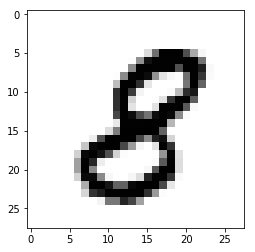

In [2]:
sample_img = mnist.train.images[5].reshape(28, 28)
plt.imshow(sample_img).set_cmap('Greys')
trainimg.shape

In [3]:
trainlabel.shape
sample_label = mnist.train.labels[5]
sample_label

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [4]:
# Parameters
_TENSORBOARD_PATH = "./tensorboard/mnist/"
if not os.path.exists(_TENSORBOARD_PATH):
    os.makedirs(_TENSORBOARD_PATH)    
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 2
# Network Parameters
n_input    = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 256 # 2nd layer num features
n_hidden_3 = 256 # 3rd layer num features
n_hidden_4 = 256 # 4th layer num features
n_classes  = 10 # MNIST total classes (0-9 digits)

# Store layers weight & bias
stddev = 0.1
with tf.variable_scope("MLP_WEIGHTS"):
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=stddev)),
        'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], stddev=stddev)),
        'out': tf.Variable(tf.random_normal([n_hidden_4, n_classes], stddev=stddev))
    }
with tf.variable_scope("MLP_BIASES"):
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

In [5]:
# Create model
def multilayer_perceptron(_X, _weights, _biases, _keep_prob):
    with tf.variable_scope("MLP_LAYER_1"):
        layer_1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1'])
                                                  , _biases['b1'])), _keep_prob)
    with tf.variable_scope("MLP_LAYER_2"):
        layer_2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2'])
                                                  , _biases['b2'])), _keep_prob)
    with tf.variable_scope("MLP_LAYER_3"):
        layer_3 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_2, _weights['h3'])
                                                  , _biases['b3'])), _keep_prob) 
    with tf.variable_scope("MLP_LAYER_OUT"):
        layer_4 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_3, _weights['h4'])
                                                  , _biases['b4'])), _keep_prob) 
    return (tf.matmul(layer_4, _weights['out']) + _biases['out'])
print ("Network ready")

Network ready


In [6]:
# tf Graph input
x = tf.placeholder("float", [None, n_input], name="MLP_INPUT_x")
y = tf.placeholder("float", [None, n_classes], name="MLP_TARGET_y")
keepratio = tf.placeholder("float", name="MLP_DROPOUT")

# Construct model
pred = multilayer_perceptron(x, weights, biases, keepratio)

# Define loss and optimizer
try:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)) # Softmax loss
except:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)) # Softmax loss
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Accuracy 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Initializing the variables
init = tf.global_variables_initializer()
print ("Network Ready")

Network Ready


In [7]:
# Do some optimizations
sess = tf.Session()
sess.run(init)

# Summary writer
tf.summary.scalar('cross_entropy', cost)
tf.summary.scalar('accuracy', accr)
merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(_TENSORBOARD_PATH, graph=sess.graph)
print ("Summary ready")

Summary ready


In [8]:
print ("Start!")
# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        summary, _ = sess.run([merged, optm], feed_dict={x: batch_xs, y: batch_ys, keepratio: 0.7})
        # Compute average loss
        avg_cost += sess.run(cost
                , feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})/total_batch
        # Add summary
        summary_writer.add_summary(summary, epoch*total_batch+i)
    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})
        print (" Training accuracy: %.3f" % (train_acc))
        test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel, keepratio:1.})
        print (" Test accuracy: %.3f" % (test_acc))
        
print ("Optimization Finished!")

Start!
Epoch: 000/010 cost: 0.493168070
 Training accuracy: 0.920
 Test accuracy: 0.936
Epoch: 002/010 cost: 0.111791424
 Training accuracy: 0.980
 Test accuracy: 0.967
Epoch: 004/010 cost: 0.070520619
 Training accuracy: 0.990
 Test accuracy: 0.972
Epoch: 006/010 cost: 0.050496400
 Training accuracy: 0.990
 Test accuracy: 0.978
Epoch: 008/010 cost: 0.037076886
 Training accuracy: 0.990
 Test accuracy: 0.974
Optimization Finished!


**Run the command line**

**tensorboard --logdir="./tensorboard"**

**Open http://localhost:6006/ into your web browser**